In [ ]:
# Install required packages
!pip install -q torch torchvision torchaudio
!pip install -q transformers scikit-learn nltk emoji tensorflow matplotlib seaborn


In [ ]:
# ============================================
# Import Libraries and Set Random Seeds
# ============================================
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [ ]:
# ============================================
# Load and Preprocess Dataset
# ============================================
TRAIN_PATH = "/content/emoHi-train.csv"
VALID_PATH = "/content/emoHi-valid.csv"
TEST_PATH  = "/content/emoHi-test.csv"

train_df = pd.read_csv(TRAIN_PATH)
valid_df = pd.read_csv(VALID_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Clean column names
for df in (train_df, valid_df, test_df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'labels' in df.columns:
        df.rename(columns={'labels':'label'}, inplace=True)

print(f"Dataset shapes - Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")
print("\nSample data:")
print(train_df.head())


Dataset shapes - Train: (43410, 3), Valid: (5426, 3), Test: (5427, 3)

Sample data:
        id label                                               text
0  eebbqej  [27]  मेरा पसंदीदा खाना कुछ भी है जो मुझे खुद नहीं ब...
1  ed00q6i  [27]  अब अगर वह खुद से दूर हो जाता है, तो हर कोई सोच...
2  eezlygj   [2]                     बकवास बेअदब आईएसओिंग क्यों है?
3  ed7ypvh  [14]                        उसे खतरा महसूस कराने के लिए
4  ed0bdzj   [3]                                डर्टी सदर्न वेंकर्स


In [ ]:
GOEMOTIONS = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion",
    "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
    "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
    "pride","realization","relief","remorse","sadness","surprise","neutral"
]
NUM_LABELS = len(GOEMOTIONS)

def parse_label(x):
    if pd.isna(x): return []
    s = str(x)
    nums = re.findall(r"\d+", s)
    return [int(v) for v in nums]

for df in (train_df, valid_df, test_df):
    df['labels_parsed'] = df['label'].apply(parse_label)

def to_multi_hot(lst):
    arr = np.zeros(NUM_LABELS, dtype=int)
    for i in lst:
        if 0 <= i < NUM_LABELS: arr[i] = 1
    return arr

y_train = np.vstack(train_df['labels_parsed'].apply(to_multi_hot))
y_valid = np.vstack(valid_df['labels_parsed'].apply(to_multi_hot))
y_test  = np.vstack(test_df['labels_parsed'].apply(to_multi_hot))

print("Multi-label shape:", y_train.shape)


Multi-label shape: (43410, 28)


In [ ]:
stop_en = set(stopwords.words('english'))
stop_hi = set(['है','थे','हो','था','हूँ','यह','वे','और','पर','को','कर','से','में','कि','भी','जो','का','की'])

def clean(t):
    t = str(t).lower()
    t = re.sub(r'[^a-zA-Z\u0900-\u097F\s]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    t = " ".join(w for w in t.split() if w not in stop_en and w not in stop_hi)
    return t

for df in (train_df, valid_df, test_df):
    df['clean'] = df['text'].apply(clean)


In [ ]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(train_df['clean'])
Xva = tfidf.transform(valid_df['clean'])
Xte = tfidf.transform(test_df['clean'])

svm = OneVsRestClassifier(LogisticRegression(max_iter=200))
svm.fit(Xtr, y_train)

svm_va_pred = svm.predict(Xva)
svm_te_pred = svm.predict(Xte)

def example_f1(y_true, y_pred):
    scores=[]
    for yt, yp in zip(y_true, y_pred):
        tp = np.sum((yt==1)&(yp==1))
        fp = np.sum((yt==0)&(yp==1))
        fn = np.sum((yt==1)&(yp==0))
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        scores.append(2*prec*rec/(prec+rec+1e-9))
    return float(np.mean(scores))

svm_valid_f1 = example_f1(y_valid, svm_va_pred)
svm_test_f1  = example_f1(y_test,  svm_te_pred)
svm_valid_acc = (y_valid == svm_va_pred).all(axis=1).mean()
svm_test_acc  = (y_test  == svm_te_pred).all(axis=1).mean()

print("SVM valid acc:", svm_valid_acc, "F1:", svm_valid_f1)
print("SVM test  acc:", svm_test_acc,  "F1:", svm_test_f1)


SVM valid acc: 0.16992259491338002 F1: 0.1931686936577553
SVM test  acc: 0.16989128431914502 F1: 0.19313924177664718


In [ ]:
MAX_LEN = 64
tok = Tokenizer(num_words=40000, oov_token="<unk>")
tok.fit_on_texts(train_df['clean'])

Xtr_lstm = pad_sequences(tok.texts_to_sequences(train_df['clean']), maxlen=MAX_LEN)
Xva_lstm = pad_sequences(tok.texts_to_sequences(valid_df['clean']), maxlen=MAX_LEN)
Xte_lstm = pad_sequences(tok.texts_to_sequences(test_df['clean']),  maxlen=MAX_LEN)

lstm = Sequential([
    Embedding(len(tok.word_index)+1, 128, input_length=MAX_LEN),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_LABELS, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(Xtr_lstm, y_train, validation_data=(Xva_lstm, y_valid), epochs=3, batch_size=64)

va_pred = (lstm.predict(Xva_lstm) >= 0.5).astype(int)
te_pred = (lstm.predict(Xte_lstm) >= 0.5).astype(int)

lstm_valid_f1 = example_f1(y_valid, va_pred)
lstm_test_f1  = example_f1(y_test,  te_pred)
lstm_valid_acc = (y_valid == va_pred).all(axis=1).mean()
lstm_test_acc  = (y_test  == te_pred).all(axis=1).mean()

print("LSTM valid acc:", lstm_valid_acc, "F1:", lstm_valid_f1)
print("LSTM test  acc:", lstm_test_acc,  "F1:", lstm_test_f1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
679/679 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - accuracy: 0.2515 - loss: 0.1942 - val_accuracy: 0.4079 - val_loss: 0.1279
Epoch 2/3
679/679 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4196 - loss: 0.1280 - val_accuracy: 0.4587 - val_loss: 0.1151
Epoch 3/3
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4744 - loss: 0.1110 - val_accuracy: 0.4705 - val_loss: 0.1127
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM valid acc: 0.3007740508661998 F1: 0.33710529499202363
LSTM test  acc: 0.2940851299060254 F1: 0.3312695775458199


In [ ]:
# ============================================
# DistilBERT Model Training (Best Model)
# ============================================
MODEL_NAME = "distilbert-base-multilingual-cased"
EPOCHS = 2
BATCH_SIZE = 16
MAX_LEN = 96
LR = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset class for PyTorch
class EmoDataset(Dataset):
    def __init__(self, texts, labels):
        self.enc = tokenizer(list(texts), truncation=True, padding=True, max_length=MAX_LEN)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets and data loaders
train_ds = EmoDataset(train_df['text'], y_train)
valid_ds = EmoDataset(valid_df['text'], y_valid)
test_ds  = EmoDataset(test_df['text'],  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, pin_memory=True)

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, problem_type="multi_label_classification"
).to(device)

# Setup optimizer and loss
opt = AdamW(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = torch.nn.BCEWithLogitsLoss()

# Training function
def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        opt.zero_grad(set_to_none=True)
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            out = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"])
            loss = loss_fn(out.logits, batch["labels"])
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Prediction function
@torch.no_grad()
def predict(loader):
    model.eval()
    preds = []
    for batch in loader:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            logits = model(input_ids=batch["input_ids"],
                           attention_mask=batch["attention_mask"]).logits
        preds.append(torch.sigmoid(logits).float().cpu().numpy())
    return np.vstack(preds)

# Train model
print("Training DistilBERT model...")
for epoch in range(EPOCHS):
    avg_loss = train_one_epoch()
    print(f"Epoch {epoch+1}/{EPOCHS} - Average Loss: {avg_loss:.4f}")

# Evaluate
print("\nEvaluating model...")
va_pred = (predict(valid_loader) >= 0.5).astype(int)
te_pred = (predict(test_loader)  >= 0.5).astype(int)

bert_valid_f1 = example_f1(y_valid, va_pred)
bert_test_f1  = example_f1(y_test,  te_pred)
bert_valid_acc = (y_valid == va_pred).all(axis=1).mean()
bert_test_acc  = (y_test  == te_pred).all(axis=1).mean()

print(f"\nDistilBERT Results:")
print(f"Validation - Accuracy: {bert_valid_acc:.3f}, F1: {bert_valid_f1:.3f}")
print(f"Test       - Accuracy: {bert_test_acc:.3f}, F1: {bert_test_f1:.3f}")

# Save model for Streamlit app
os.makedirs("models", exist_ok=True)
model.save_pretrained("models/distilbert-emotion")
tokenizer.save_pretrained("models/distilbert-emotion")
print("\n✅ Model saved to 'models/distilbert-emotion'")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT model...
Epoch 1/2 - Average Loss: 0.1361
Epoch 2/2 - Average Loss: 0.1005

Evaluating model...

DistilBERT Results:
Validation - Accuracy: 0.360, F1: 0.408
Test       - Accuracy: 0.355, F1: 0.400

✅ Model saved to 'models/distilbert-emotion'


In [ ]:
# Model is loaded as 'model' variable
print("✅ DistilBERT model is ready for inference!")


✅ DistilBERT model is ready for inference!


In [ ]:
# ============================================
# Emotion Prediction Function
# ============================================
THRESHOLD = 0.5

def predict_text(text, top_k=None, threshold=THRESHOLD):
    """
    Predict emotions from text input.

    Args:
        text: Input text (Hindi/Hinglish)
        top_k: Return top k emotions (if None, uses threshold)
        threshold: Minimum probability threshold (default: 0.5)

    Returns:
        List of (emotion, probability) tuples
    """
    enc = tokenizer([text], truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    if top_k:
        idx = np.argsort(probs)[-top_k:][::-1]
        return [(GOEMOTIONS[i], float(probs[i])) for i in idx]

    result = [(GOEMOTIONS[i], float(probs[i])) for i in range(len(probs)) if probs[i] >= threshold]
    result = sorted(result, key=lambda x: x[1], reverse=True)

    if not result:
        idx = int(np.argmax(probs))
        result = [(GOEMOTIONS[idx], float(probs[idx]))]

    return result

print("✅ Prediction function ready!")


✅ Prediction function ready!


In [ ]:
print(predict_text("मुझे बहुत गुस्सा आ रहा है"))


[('anger', 0.6366593241691589)]


In [ ]:
print(predict_text("मैं खुश हूँ"))

[('joy', 0.7279137372970581)]


In [ ]:
print(predict_text("मैं बहुत परेशान हूँ, मुझे खेद है"))

[('remorse', 0.7390455603599548)]


In [ ]:
results = [
    ["SVM",  svm_valid_acc,  svm_valid_f1,  svm_test_acc,  svm_test_f1],
    ["LSTM", lstm_valid_acc, lstm_valid_f1, lstm_test_acc, lstm_test_f1],
    ["BERT", bert_valid_acc, bert_valid_f1, bert_test_acc, bert_test_f1],
]
dfres = pd.DataFrame(results, columns=["Model","Valid_Acc","Valid_F1","Test_Acc","Test_F1"])
os.makedirs("results", exist_ok=True)
dfres.to_csv("results/metrics.csv", index=False)
dfres


,Model,Valid_Acc,Valid_F1,Test_Acc,Test_F1
0,SVM,0.169923,0.193169,0.169891,0.193139
1,LSTM,0.300774,0.337105,0.294085,0.331270
2,BERT,0.359934,0.408263,0.355445,0.400461


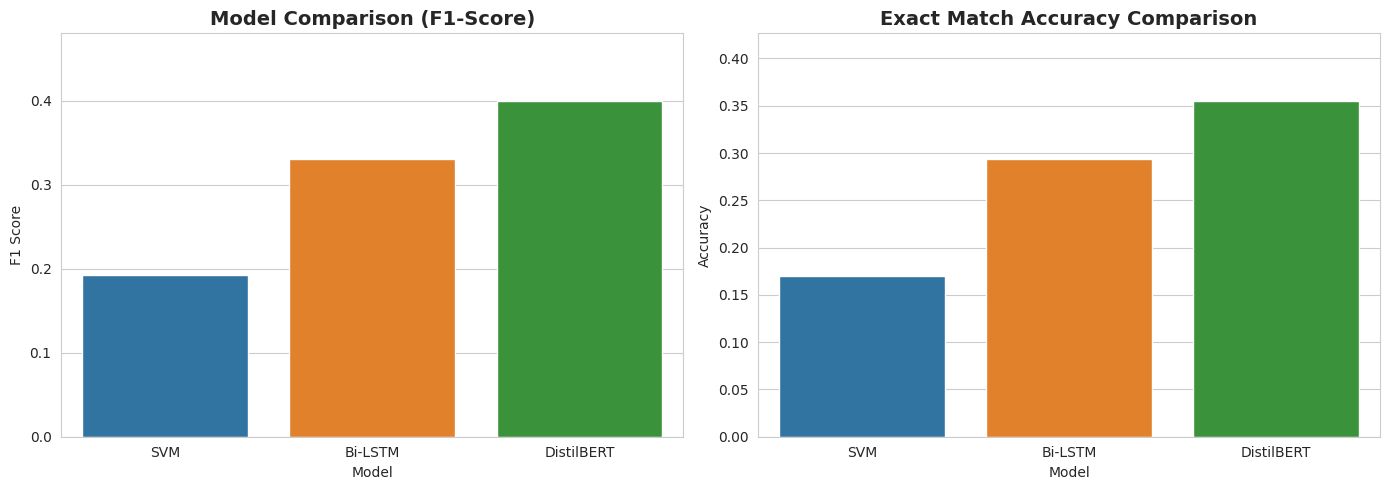

/tmp/ipython-input-2569169892.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=label_counts.values, palette="viridis")


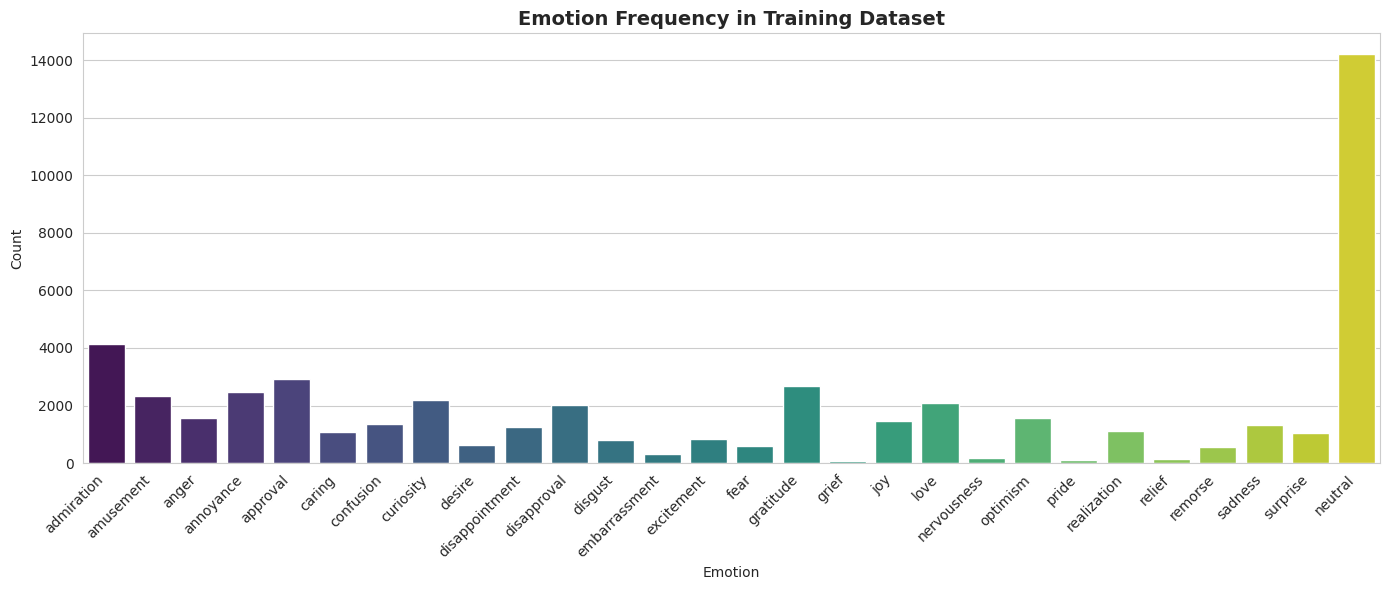

/tmp/ipython-input-2569169892.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=GOEMOTIONS, x=bert_f1_per_label, palette="coolwarm")


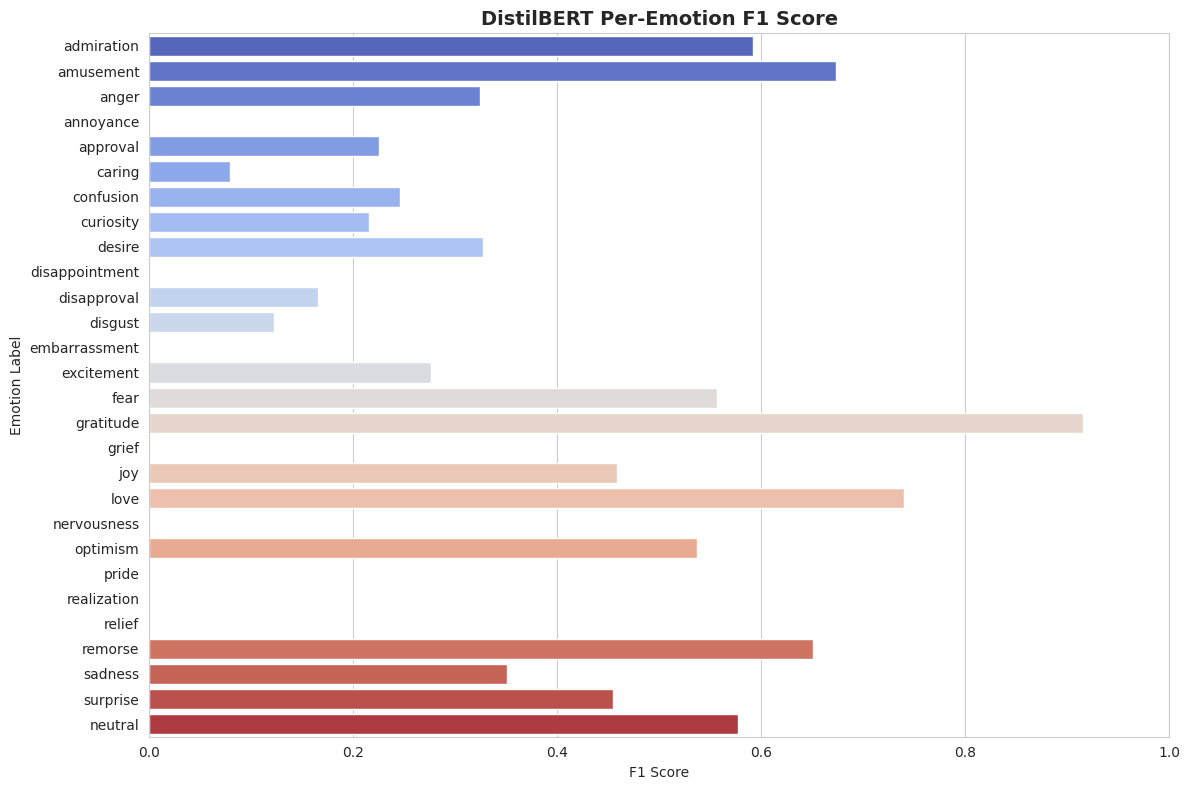

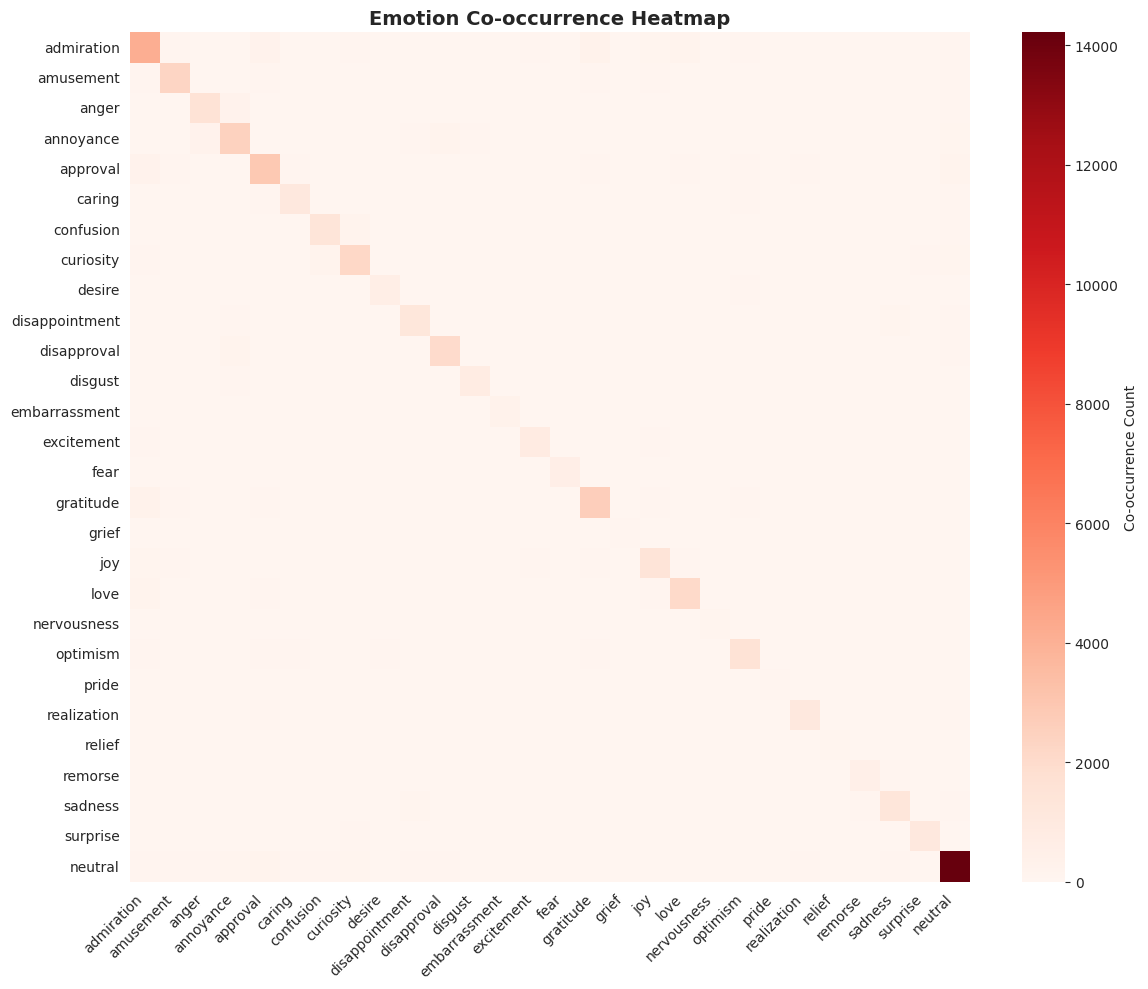

✅ Visualizations completed and results saved!

Model Performance Summary:
Model  Valid_Acc  Valid_F1  Test_Acc  Test_F1
  SVM   0.169923  0.193169  0.169891 0.193139
 LSTM   0.300774  0.337105  0.294085 0.331270
 BERT   0.359934  0.408263  0.355445 0.400461


In [ ]:
# ==========================================
# Visualization & Analysis Section
# ==========================================
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# -----------------------------
# 1. Model Comparison Chart
# -----------------------------
models = ["SVM", "Bi-LSTM", "DistilBERT"]
f1_scores = [svm_test_f1, lstm_test_f1, bert_test_f1]
accuracies = [svm_test_acc, lstm_test_acc, bert_test_acc]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=models, y=f1_scores, ax=ax1, hue=models, legend=False)
ax1.set_title("Model Comparison (F1-Score)", fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(f1_scores) * 1.2)
ax1.set_ylabel("F1 Score")
ax1.set_xlabel("Model")

sns.barplot(x=models, y=accuracies, ax=ax2, hue=models, legend=False)
ax2.set_title("Exact Match Accuracy Comparison", fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(accuracies) * 1.2)
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Model")

plt.tight_layout()
plt.show()

# -----------------------------
# 2. Emotion Distribution in Dataset
# -----------------------------
all_labels = []
for labels in train_df['labels_parsed']:
    all_labels.extend(labels)

label_counts = pd.Series(all_labels).value_counts().sort_index()
label_names = [GOEMOTIONS[i] for i in label_counts.index]

plt.figure(figsize=(14, 6))
sns.barplot(x=label_names, y=label_counts.values, palette="viridis")
plt.title("Emotion Frequency in Training Dataset", fontsize=14, fontweight='bold')
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Per-Label F1 Score (DistilBERT)
# -----------------------------
bert_f1_per_label = f1_score(y_test, te_pred, average=None, zero_division=0)

plt.figure(figsize=(12, 8))
sns.barplot(y=GOEMOTIONS, x=bert_f1_per_label, palette="coolwarm")
plt.title("DistilBERT Per-Emotion F1 Score", fontsize=14, fontweight='bold')
plt.xlabel("F1 Score")
plt.ylabel("Emotion Label")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Label Co-occurrence Heatmap
# -----------------------------
co_matrix = np.dot(y_train.T, y_train)
plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix, cmap="Reds", xticklabels=GOEMOTIONS, yticklabels=GOEMOTIONS,
            fmt='d', cbar_kws={'label': 'Co-occurrence Count'})
plt.title("Emotion Co-occurrence Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Save Results
# -----------------------------
os.makedirs("results/plots", exist_ok=True)
results = [
    ["SVM",  svm_valid_acc,  svm_valid_f1,  svm_test_acc,  svm_test_f1],
    ["LSTM", lstm_valid_acc, lstm_valid_f1, lstm_test_acc, lstm_test_f1],
    ["BERT", bert_valid_acc, bert_valid_f1, bert_test_acc, bert_test_f1],
]
dfres = pd.DataFrame(results, columns=["Model","Valid_Acc","Valid_F1","Test_Acc","Test_F1"])
dfres.to_csv("results/metrics.csv", index=False)

print("✅ Visualizations completed and results saved!")
print("\nModel Performance Summary:")
print(dfres.to_string(index=False))


In [ ]:
# 1. Install both streamlit and pyngrok
!pip install streamlit pyngrok
import streamlit as st

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 139.0 MB/s eta 0:00:00


In [ ]:
# Install Streamlit & Pyngrok
!pip install streamlit pyngrok -q

from pyngrok import ngrok

# --- IMPORTANT: Put your actual ngrok token here ---
NGROK_AUTH_TOKEN = "35Pgkskr7QIfK9CcOg7XeoOEVbe_6iNnQznt3s4JTu7hx3exC"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill all previous ngrok processes/tunnels
# This is a crucial step to free up resources and the local API port (4040)
ngrok.kill()

# Start Streamlit in the background
# The Streamlit app runs on port 8501
print("Starting Streamlit app in the background...")
!nohup streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &>/dev/null &

# Give Streamlit a moment to start up (crucial for stability in notebooks)
import time
time.sleep(3)

# Create public URL: Use the default behavior to get a random, available URL.
# The `bind_addr` is the port your Streamlit app is listening on (8501).
# We omit the 'hostname' parameter to avoid the ERR_NGROK_334 issue.
try:
    public_url = ngrok.connect(8501, "http")
    print("\n Your Streamlit app is ready! Open the link below:")
    print(public_url)
except Exception as e:
    print(f"\nAn error occurred while connecting ngrok: {e}")
    print("Please check your ngrok auth token and ensure your app is running.")# Install Streamlit & Pyngrok
!pip install streamlit pyngrok -q

from pyngrok import ngrok

# --- IMPORTANT: Put your actual ngrok token here ---
NGROK_AUTH_TOKEN = "35Pgkskr7QIfK9CcOg7XeoOEVbe_6iNnQznt3s4JTu7hx3exC"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill all previous ngrok processes/tunnels
# This is a crucial step to free up resources and the local API port (4040)
ngrok.kill()

# Start Streamlit in the background
# The Streamlit app runs on port 8501
print("Starting Streamlit app in the background...")
!nohup streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &>/dev/null &

# Give Streamlit a moment to start up (crucial for stability in notebooks)
import time
time.sleep(3)

# Create public URL: Use the default behavior to get a random, available URL.
# The `bind_addr` is the port your Streamlit app is listening on (8501).
# We omit the 'hostname' parameter to avoid the ERR_NGROK_334 issue.
try:
    public_url = ngrok.connect(8501, "http")
    print("\n Your Streamlit app is ready! Open the link below:")
    print(public_url)
except Exception as e:
    print(f"\nAn error occurred while connecting ngrok: {e}")
    print("Please check your ngrok auth token and ensure your app is running.")

Starting Streamlit app in the background...



An error occurred while connecting ngrok: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://areally-psychrometrical-wendolyn.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}

Please check your ngrok auth token and ensure your app is running.
Starting Streamlit app in the background...



An error occurred while connecting ngrok: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://areally-psychrometrical-wendolyn.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}

Please check your ngrok auth token and ensure your app is running.


In [ ]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501

34.87.120.98
⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.87.120.98:8502

your url is: https://wide-lands-retire.loca.lt
